In [12]:
import numpy as np
import tensorflow as tf
import pandas as pd
import pickle 
import matplotlib.pyplot as plt

'''
import keras 
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
'''

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score

import xgboost as xgb

from mlens.metrics import wape, make_scorer

In [3]:
data = pd.read_csv("Data/diabetes_dataset.csv")
print(data.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [4]:
x, y = data.iloc[:,:-1],data.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15)

data_dmatrix = xgb.DMatrix(data=x,label=y,feature_names=x.columns.values)

In [ ]:
## Cleaning the data by replacing 0 "skews" with NaN and then the median values

In [18]:
## Creating the Model
model_xgb = xgb.XGBClassifier(objective ='reg:squarederror', gamma=3.7, 
                             min_child_weight=14, loss="ls", colsample_bytree=1, 
                             max_depth=4, learning_rate=0.05, alpha=7, 
                             n_estimators = 300, subsample=1)
model_xgb.fit(x_train, y_train)
predictions = model_xgb.predict(x_test)

[00:22:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [19]:
## Testing

accuracy = cross_val_score(estimator = model_xgb, X = x_train, y = y_train, cv = 10)
print("Cross Validation accuracy:" ,accuracy.mean())

score = model_xgb.score(x_train, y_train)  
print("Score:", score)

error = wape(y_test, predictions)
print("error:", error)


[00:22:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:22:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:22:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  

[00:12:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




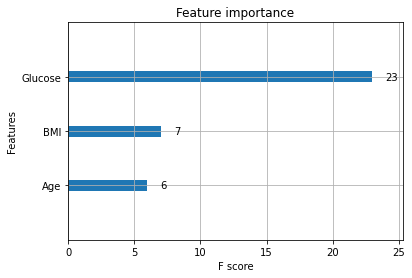

In [13]:
## Import Feature Search

params = {'alpha': 11, 'colsample_bytree': 1, 'gamma': 3.7, 'learning_rate': 0.05, 
'max_depth': 7, 'min_child_weight': 14, 'n_estimators': 299, 'subsample': 1}
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

xgb.plot_importance(model_xgb)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [25]:
## GBC Model

from sklearn.ensemble import GradientBoostingClassifier
model_gbc = GradientBoostingClassifier( learning_rate=0.2, n_estimators=200, max_depth=5, subsample=1, verbose=False)
model_gbc.fit(x_train,y_train)

predictions = model_gbc.predict(x_test)

acc_gbc = cross_val_score(estimator = model_gbr, X = x_train, y = y_train, cv = 10)
print("GB_Acc : ", acc_gbc.mean())

error = wape(y_test, predictions)
print("error:", error)


ValueError: Expected 2D array, got 1D array instead:
array=[1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [24]:
## Hyperparameter Optimization using Grid Search Cross Validation
from sklearn.model_selection import GridSearchCV

parameters = [{'loss': ['ls','huber'], 'learning_rate': [0.01, 0.05, 0.07, 0.1, 0.15, 0.2], 'n_estimators': [200],'max_depth': [3, 5], 'subsample' : [1] },
{'loss': ['ls','huber'], 'learning_rate': [0.05, 0.07, 0.2], 'n_estimators': [350],'max_depth': [6], 'subsample' : [1] },
{'loss': ['ls','huber'], 'n_estimators': [100],'learning_rate': [0.1], 'max_depth': [4], 'subsample' : [1] }]

#XGB model
gs_xgb = GridSearchCV(estimator = model_xgb, param_grid = parameters, scoring = 'explained_variance', cv = 10, n_jobs = -1)
gs_xgb.fit(x_train,y_train)
print("Best accuracy(XGB):", gs_xgb.best_score_)
print("Best Parameters(XGB):", gs_xgb.best_params_)

#gbr MODEL
gs_gbc = GridSearchCV(estimator = model_gbr, param_grid = parameters, scoring = 'explained_variance', cv = 10, n_jobs = -1)
gs_gbc.fit(x_train,y_train)
print("Best accuracy(GBR):", gs_gbc.best_score_)
print("Best Parameters(GBR):", gs_gbc.best_params_)


[00:36:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Best accuracy(XGB): 0.01385979242744576
Best Parameters(XGB): {'learning_rate': 0.05, 'loss': 'ls', 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}
Best accuracy(GBR): 0.30103739273290187
Best Parameters(GBR): {'learning_rate': 0.01, 'loss': 'huber', 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}
